# Tomato Disease Classification
Dataset: https://www.kaggle.com/arjuntejaswi/plant-village + Added images from Google

---

### 1. Importing Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### 2. Importing data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=786,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 6406 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early_Blight',
 'Late_Blight',
 'Septoria_Leaf_Spot',
 'Tomato_Healthy',
 'Yellow_Leaf_Curl_Virus']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

#Each batch contains 32 images of size 256x256x3

(32, 256, 256, 3)
[3 4 1 0 2 1 4 2 4 3 1 3 2 2 0 0 1 0 2 1 1 0 2 0 4 3 1 3 3 4 2 2]


### 3. Visualization

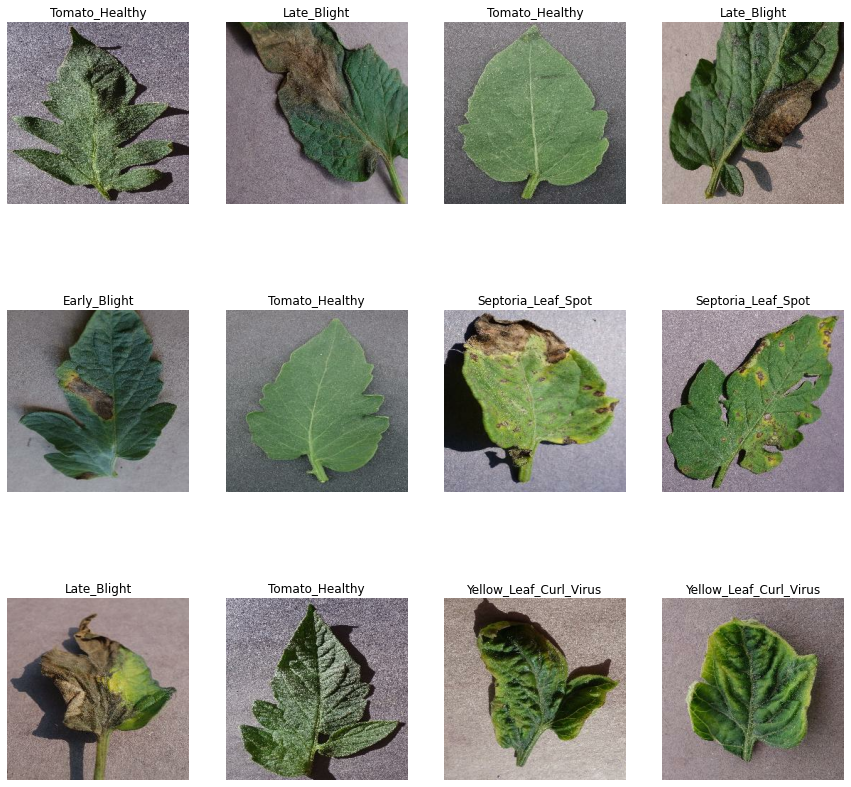

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### 4. Splitting Dataset
Dataset is split into following 3 parts:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [7]:
def split_dataset(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [9]:
#Number of batches in training dataset
len(train_ds)

140

In [10]:
#Number of batches in validation dataset
len(val_ds)

40

In [11]:
#Number of batches in testing dataset
len(test_ds)

21

### 5. Cache, Shuffle, and Prefetch the Dataset

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### 6. Building the Model

In [13]:
#Layer for Resizing and Normalization

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
#Data Augmentation: Flipping and Rotation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
#Applying data augmentation on training dataset

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#Building the model

input_shape = (32,256,256,3)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [18]:
#Model compilation

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
140/140 [==============================] - 408s 3s/step - loss: 1.2175 - accuracy: 0.4750 - val_loss: 1.0331 - val_accuracy: 0.5531
Epoch 2/50
140/140 [==============================] - 340s 2s/step - loss: 0.8763 - accuracy: 0.6547 - val_loss: 1.0755 - val_accuracy: 0.5906
Epoch 3/50
140/140 [==============================] - 341s 2s/step - loss: 0.7977 - accuracy: 0.6953 - val_loss: 0.9253 - val_accuracy: 0.6547
Epoch 4/50
140/140 [==============================] - 353s 3s/step - loss: 0.7346 - accuracy: 0.7147 - val_loss: 0.6849 - val_accuracy: 0.7469
Epoch 5/50
140/140 [==============================] - 484s 3s/step - loss: 0.6205 - accuracy: 0.7656 - val_loss: 0.5626 - val_accuracy: 0.8039
Epoch 6/50
140/140 [==============================] - 580s 4s/step - loss: 0.5283 - accuracy: 0.7955 - val_loss: 0.4874 - val_accuracy: 0.8273
Epoch 7/50
140/140 [==============================] - 478s 3s/step - loss: 0.4813 - accuracy: 0.8183 - val_loss: 0.5906 - val_accuracy: 0.7977

In [20]:
model.save('trained_model_new.h5')

### 7. Model Evaluation

In [21]:
model.evaluate(test_ds)

21/21 [==============================] - 70s 410ms/step - loss: 0.1041 - accuracy: 0.9717


[0.1041039526462555, 0.9717261791229248]

### 8. Plotting Graphs

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

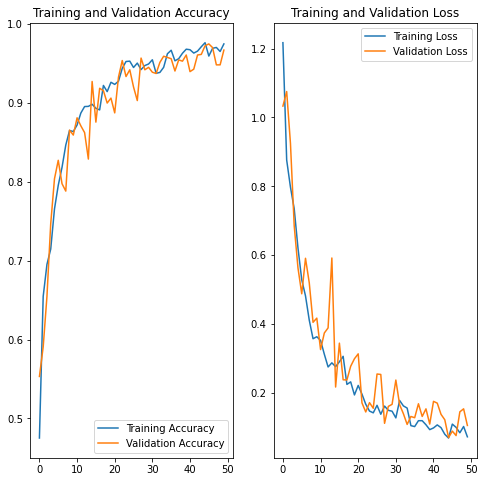

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Prediction

In [159]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

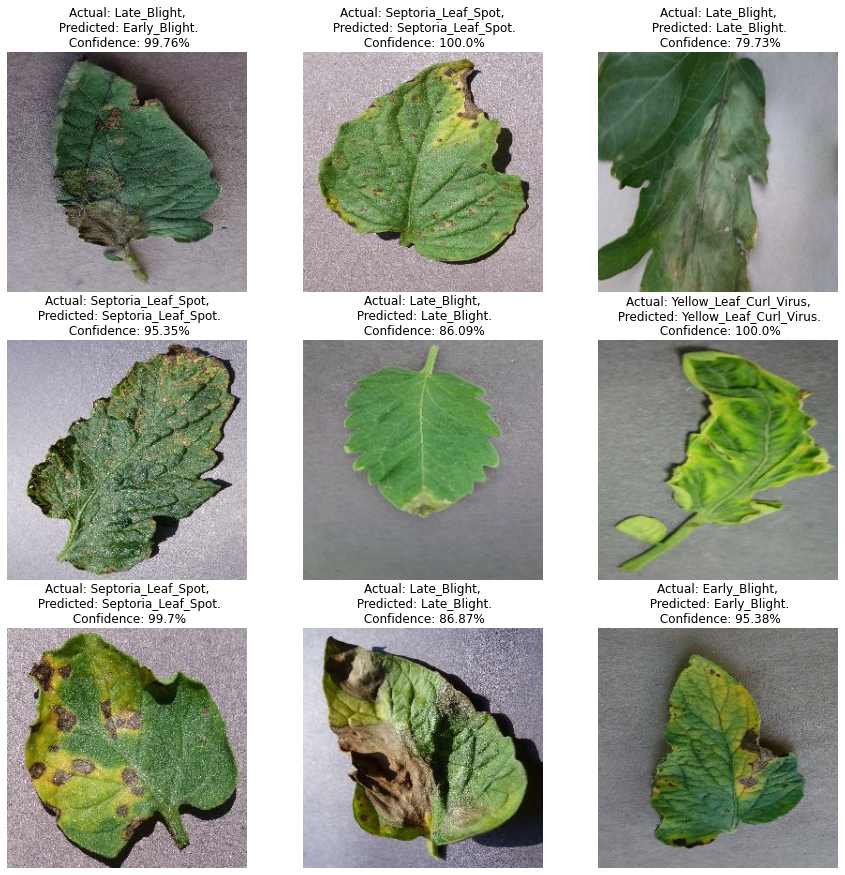

In [128]:
#Testing for a few images from test dataset

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")